## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import pickle
import tracker
import matplotlib.pyplot as plt
%matplotlib inline
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

In [2]:
images

['camera_cal\\calibration1.jpg',
 'camera_cal\\calibration10.jpg',
 'camera_cal\\calibration11.jpg',
 'camera_cal\\calibration12.jpg',
 'camera_cal\\calibration13.jpg',
 'camera_cal\\calibration14.jpg',
 'camera_cal\\calibration15.jpg',
 'camera_cal\\calibration16.jpg',
 'camera_cal\\calibration17.jpg',
 'camera_cal\\calibration18.jpg',
 'camera_cal\\calibration19.jpg',
 'camera_cal\\calibration2.jpg',
 'camera_cal\\calibration20.jpg',
 'camera_cal\\calibration3.jpg',
 'camera_cal\\calibration4.jpg',
 'camera_cal\\calibration5.jpg',
 'camera_cal\\calibration6.jpg',
 'camera_cal\\calibration7.jpg',
 'camera_cal\\calibration8.jpg',
 'camera_cal\\calibration9.jpg']

In [3]:

# Step through the list and search for chessboard corners
def get_points(images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints,imgpoints


In [4]:
objpoints,imgpoints = get_points(images)
img = cv2.imread(images[0])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], 9, 6)

In [5]:
dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle, open( "./calibration_pickle.p", "wb"))

In [6]:
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

In [7]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2+sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sxbinary
    

In [8]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

In [9]:
def color_threshold(img,v_thresh = (170,255),s_thresh = (125,255),l_thresh = (220,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
    s = hls[:,:,2]
    l = hls[:,:,1]
    s_binary = np.zeros_like(s)
    s_binary[(s > s_thresh[0]) & (s <= s_thresh[1])] = 1
    
    l_binary = np.zeros_like(l)
    l_binary[(l > l_thresh[0]) & (l <= l_thresh[1])] = 1

    v = hsv[:,:,2]
    v_binary = np.zeros_like(v)
    v_binary[(v > v_thresh[0]) & (v <= v_thresh[1])] = 1
    
    binary_output = np.zeros_like(s)
    binary_output[(((s_binary == 1)&(l_binary == 1)) & (v_binary == 1))] = 1
    return binary_output


## And so on and so forth...

In [10]:
test_images = glob.glob('test_images/test*.jpg')

In [24]:
def wrap_up_image(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('output_images/distortion.jpg',undist)
    image_process = np.zeros_like(img[:,:,0])
    
    sobel_x = abs_sobel_thresh(img, orient='x', thresh=(12,255))
    sobel_y = abs_sobel_thresh(img, orient='y', thresh=(25,255))
    mag_binary = mag_thresh(img, 15, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, 15, thresh=(0.7, 1.3))
    combined_grad = np.zeros_like(image_process)
    #combined_grad[((sobel_x == 1) & (sobel_y == 1)) | ((dir_binary == 1))] = 1
    combined_grad[((sobel_x == 1) &(dir_binary == 1))] = 1
    color = color_threshold(img,v_thresh = (60,255),s_thresh = (80,255),l_thresh = (150,255))
    
    image_process[(combined_grad == 1)|(color==1)] =255
    cv2.imwrite('output_images/binary.jpg',image_process)
    
    
    img_size = (img.shape[1],img.shape[0])
    bot_width = .76
    mid_width = .08
    hight_pct = .62
    bottom_trim = .935
    spec = np.float32()
    
    src = np.float32([[img.shape[1]*(.5-mid_width/2), img.shape[0]*hight_pct],
                      [img.shape[1]*(.5+mid_width/2), img.shape[0]*hight_pct],
                      [img.shape[1]*(.5+bot_width/2), img.shape[0]*bottom_trim],
                      [img.shape[1]*(.5-bot_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*.25
    dst = np.float32([[offset, 0], 
                  [img_size[0]-offset, 0], 
                  [img_size[0]-offset, img_size[1]],
                  [offset, img_size[1]]])

    #Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)
    #Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)
    #Warp an image using the perspective transform, M:
    warped = cv2.warpPerspective(image_process, M, img_size, flags=cv2.INTER_LINEAR)
    cv2.imwrite('output_images/perspective.jpg',warped)
    return warped,Minv


In [25]:
def get_lane_curvature(img):
    
    binary_warped,_ = wrap_up_image(img)

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # OUT IMAGE # 1
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # OUT IMAGE # 2
    
    # Create an image to draw on and an image to show the selection window
    out_img2 = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img2)
    # Color in left and right line pixels
    out_img2[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img2[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img2, 1, window_img, 0.3, 0)
    
    return (ploty, left_fit, left_fitx, right_fit, right_fitx, out_img, result, leftx, rightx)

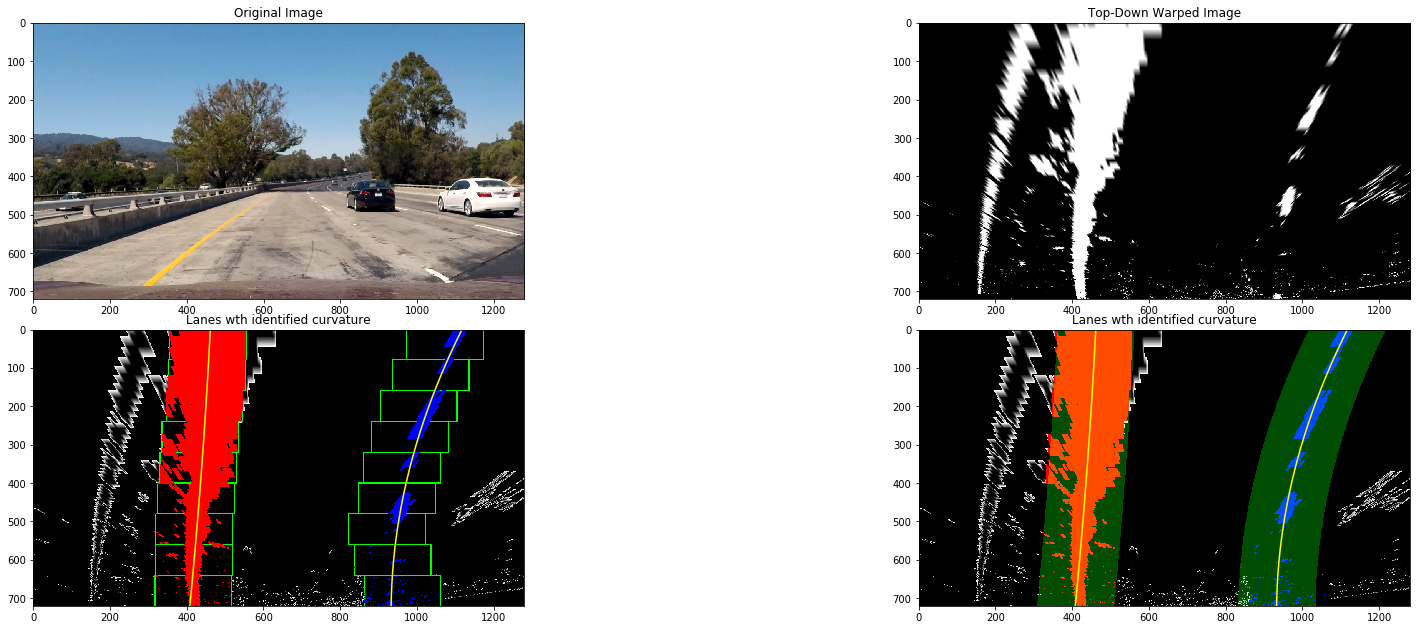

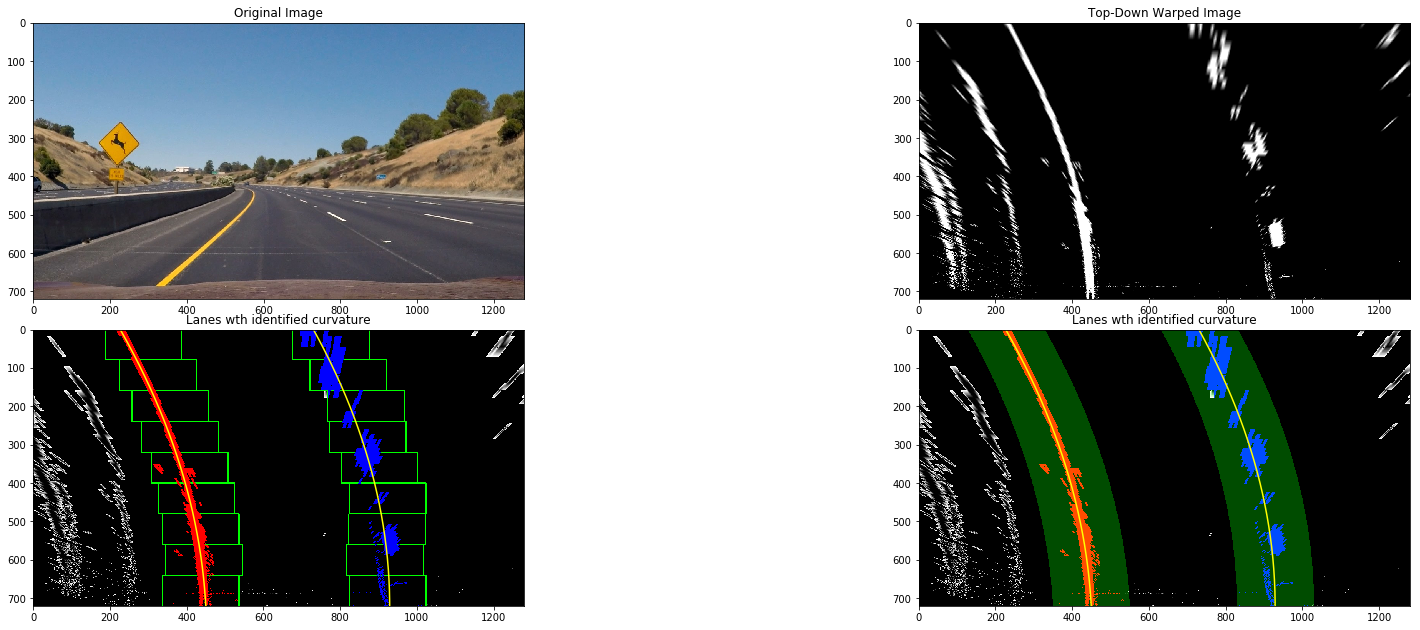

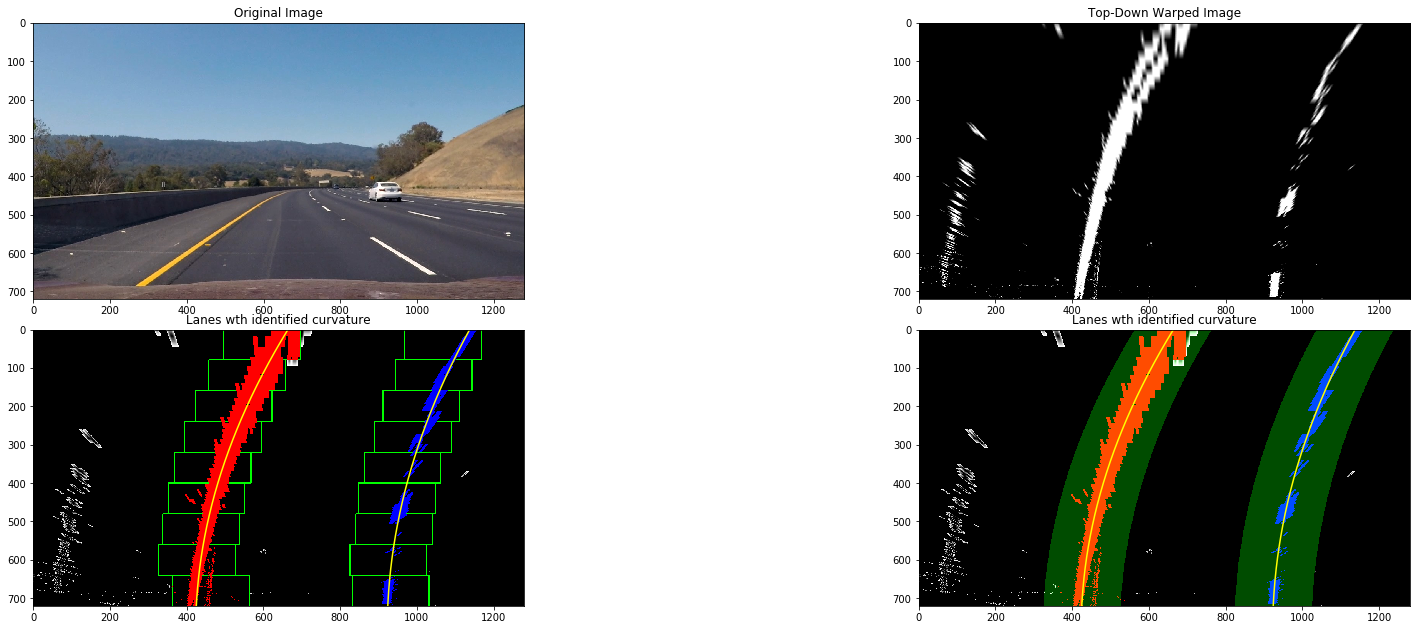

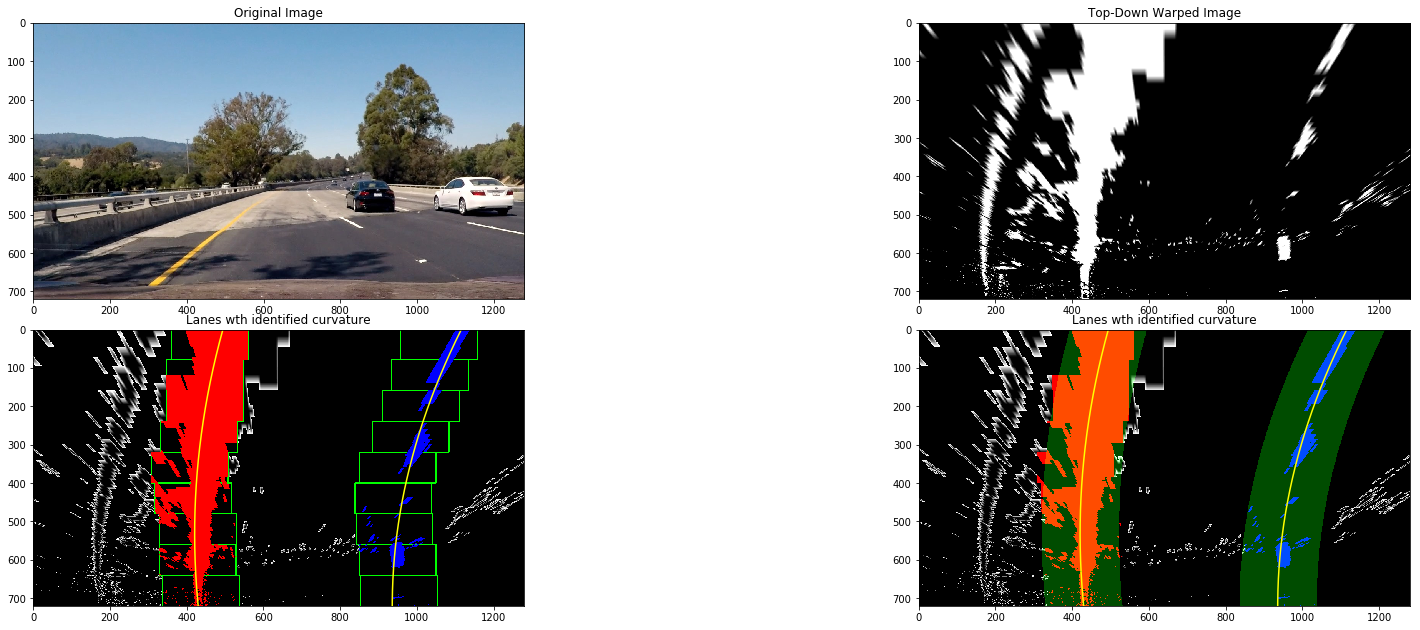

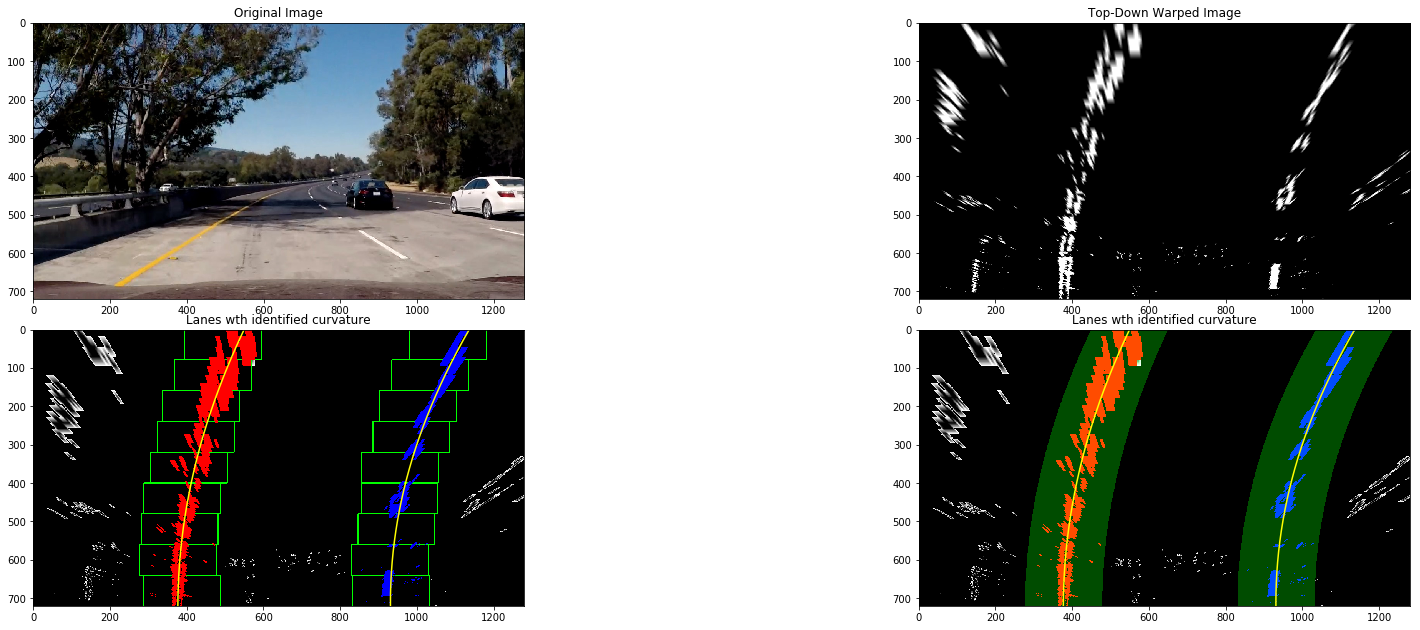

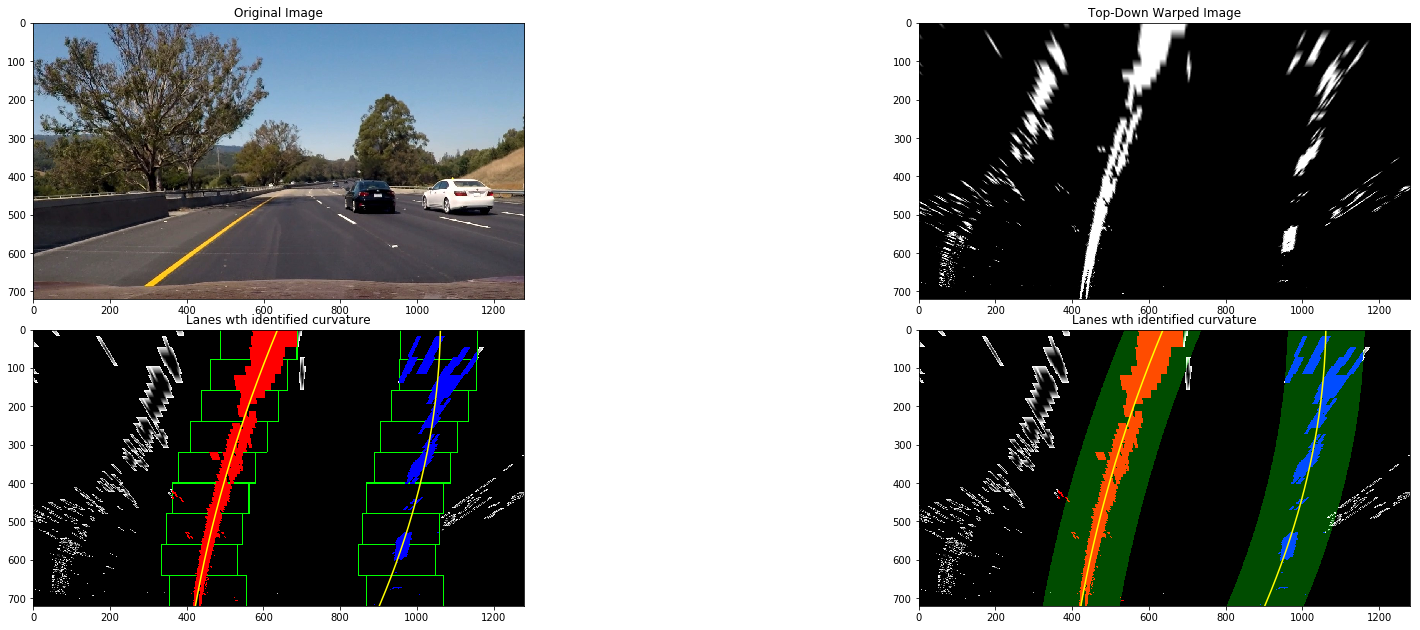

In [26]:
images = glob.glob('test_images/test*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    binary_warped_top_down,_ = wrap_up_image(img)
    ploty, left_fit, left_fitx, right_fit, right_fitx, out_img, out_img2, leftx, rightx = get_lane_curvature(img)
    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=12)
    
    ax2.imshow(binary_warped_top_down, cmap='gray')
    ax2.set_title('Top-Down Warped Image', fontsize=12)

    ax3.imshow(out_img)
    ax3.plot(left_fitx, ploty, color='yellow')
    ax3.plot(right_fitx, ploty, color='yellow')
    ax3.set_xlim([0,1280])
    ax3.set_ylim([720,0])
    ax3.set_title('Lanes wth identified curvature', fontsize=12)

    ax4.imshow(out_img2)
    ax4.plot(left_fitx, ploty, color='yellow')
    ax4.plot(right_fitx, ploty, color='yellow')
    ax4.set_xlim([0,1280])
    ax4.set_ylim([720,0])
    ax4.set_title('Lanes wth identified curvature', fontsize=12)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

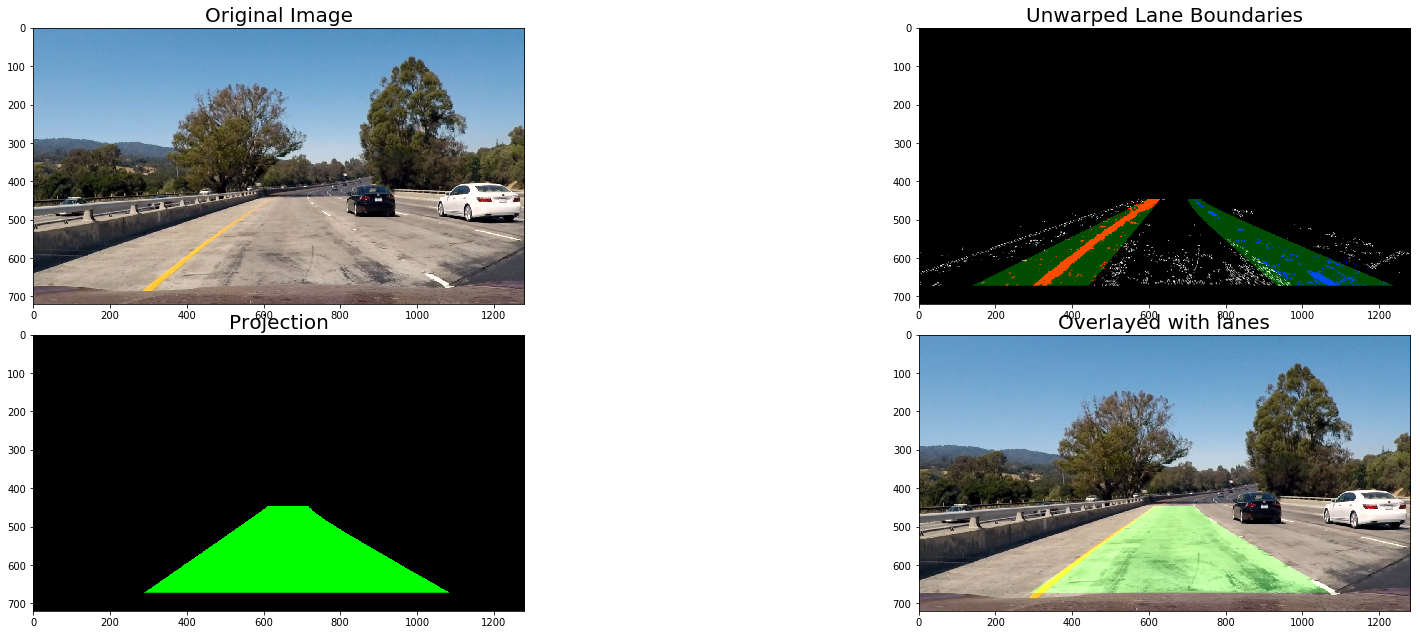

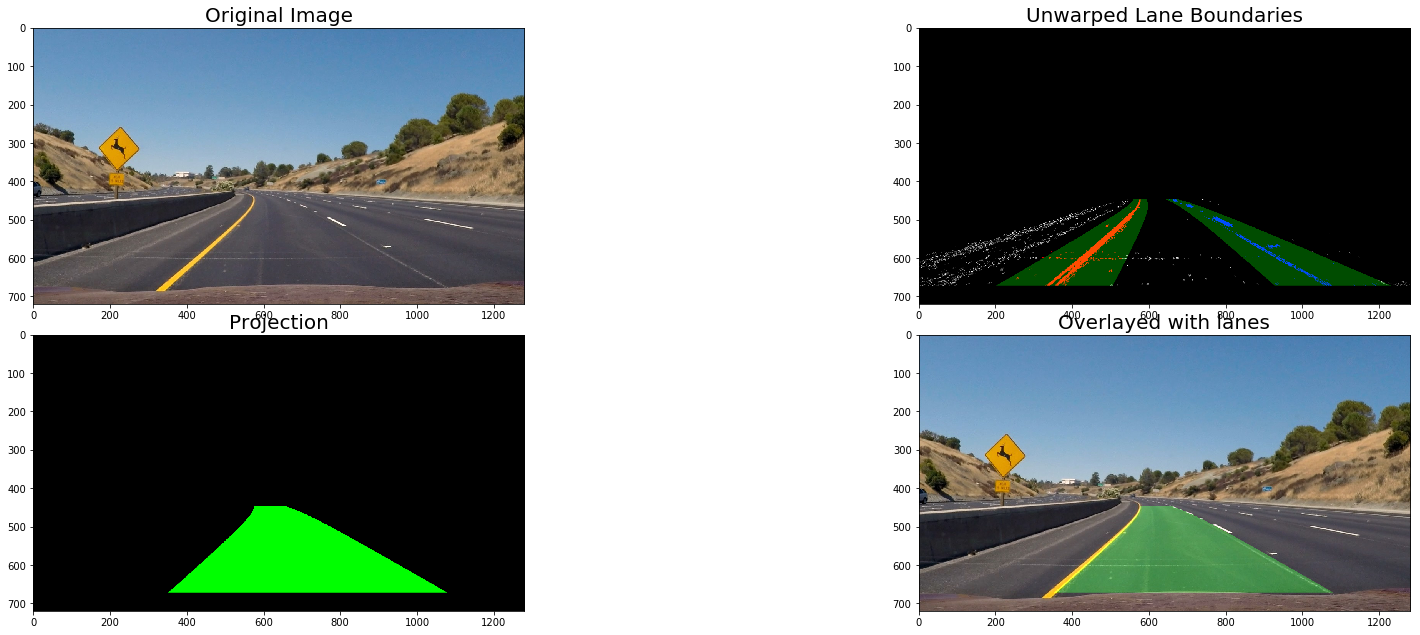

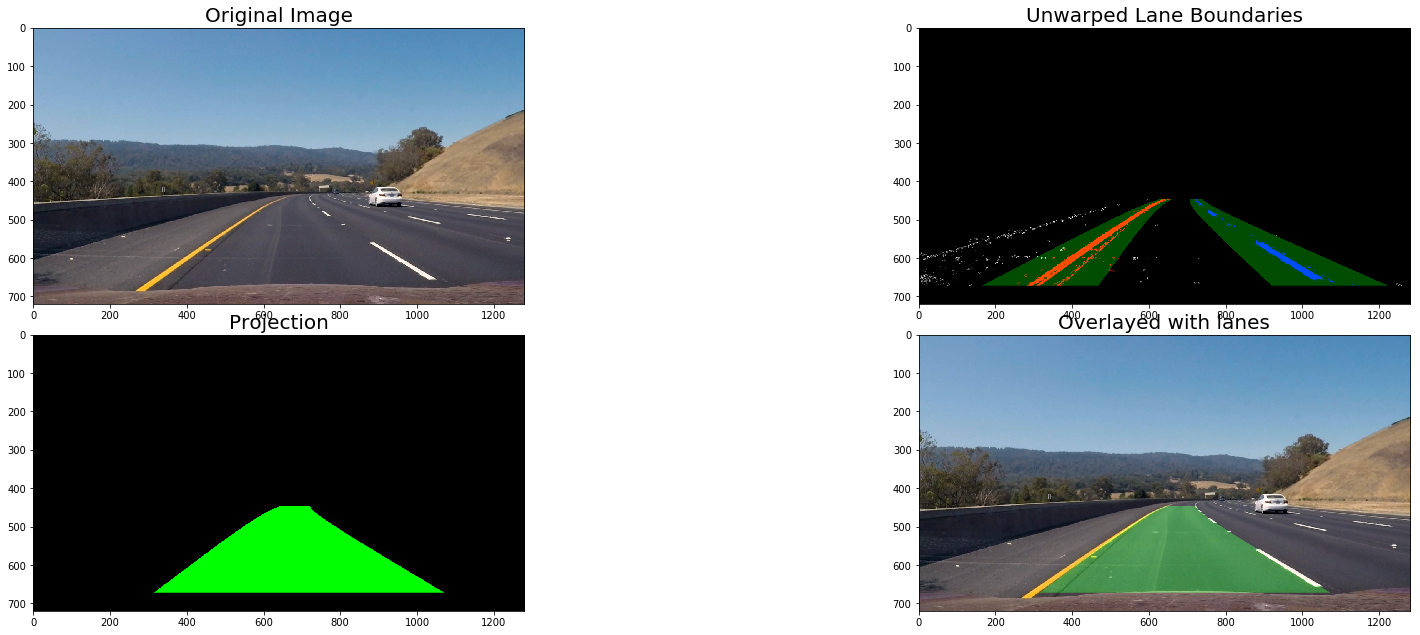

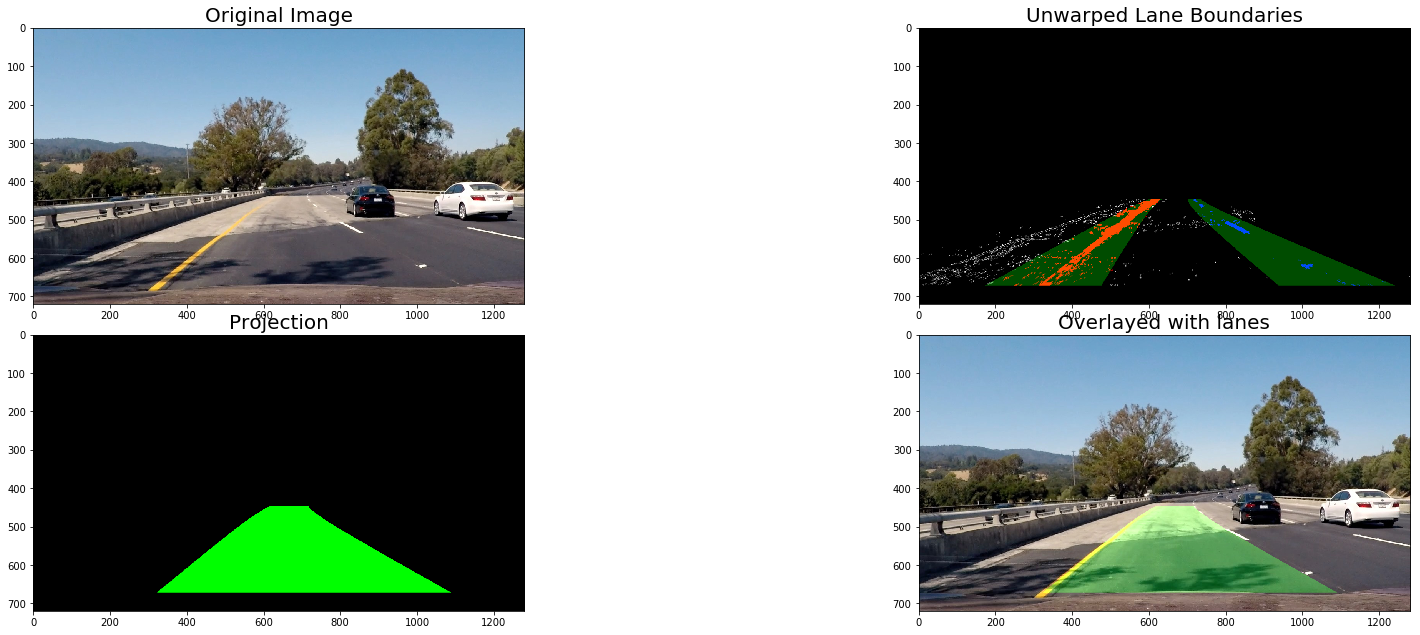

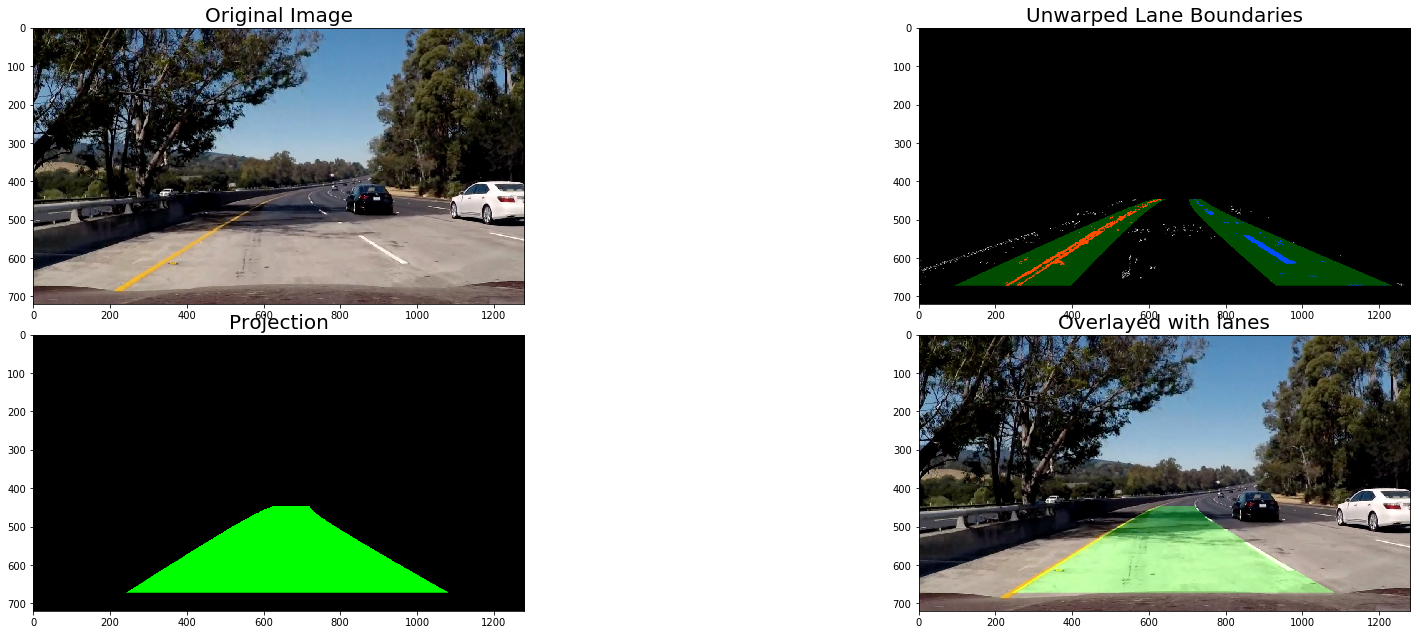

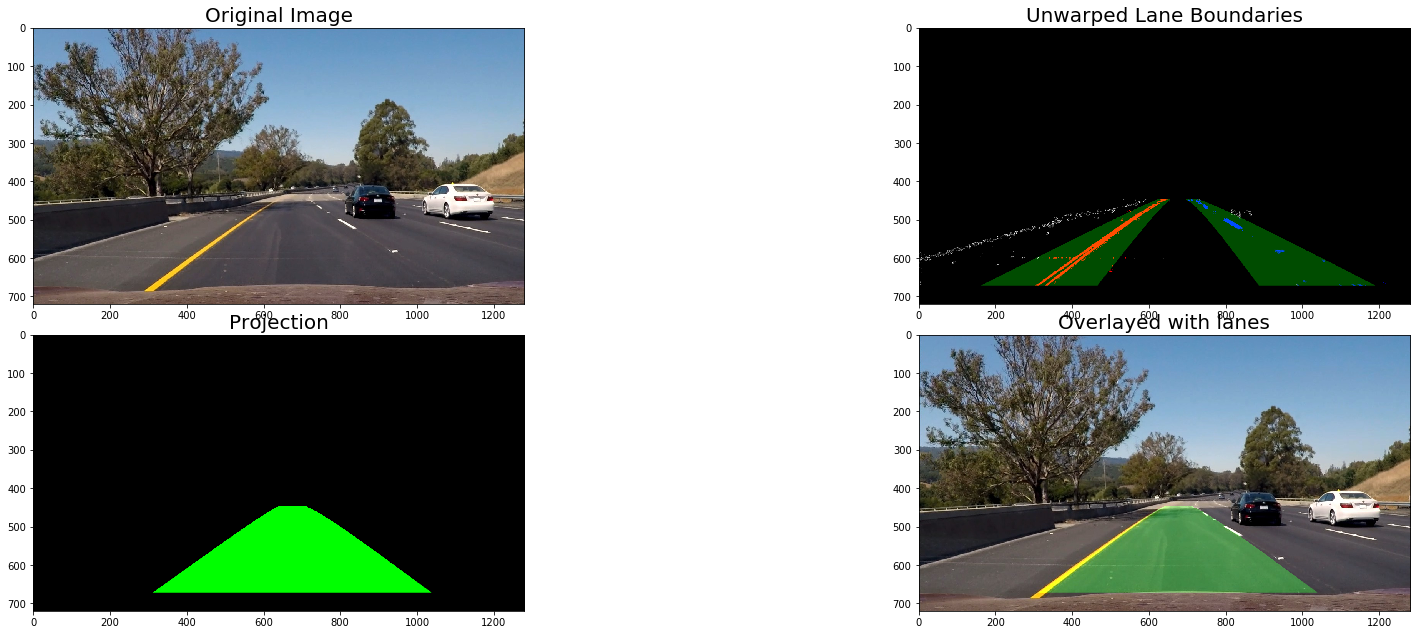

In [27]:
def project_detected_lanes(undist, warped, left_fitx, right_fitx, ploty, M):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))   
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, M, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return newwarp, result


def unwarp_and_overlay(img):
    ploty, left_fit, left_fitx, right_fit, right_fitx, out_img, out_img2, leftx, rightx = get_lane_curvature(img)
    warped,minv = wrap_up_image(img)
    projection, overlayed = project_detected_lanes(img, warped, left_fitx, right_fitx, ploty, minv)
    width = img.shape[1]
    height = img.shape[0]
    unwarped = cv2.warpPerspective(out_img2, minv, (width,height), flags=cv2.INTER_LINEAR)
    
    return unwarped, projection, overlayed


# TEST
images = glob.glob('test_images/test*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    unwarped_lane_boundaries, projection, result = unwarp_and_overlay(img)
    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)
    
    ax2.imshow(unwarped_lane_boundaries)
    ax2.set_title('Unwarped Lane Boundaries', fontsize=20)

    ax3.imshow(projection)
    ax3.set_title('Projection', fontsize=20)
    
    ax4.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    ax4.set_title('Overlayed with lanes', fontsize=20)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [28]:
images = glob.glob('test_images/test*.jpg')

window_width = 25
window_height = 80
ym_ppx = 30/720 # meter per pixel in y axis 
xm_ppx = 3.7/525 # meter per pixel in x axis 


def main_process(img):
    warped,Minv = wrap_up_image(img)
    ploty, left_fit, left_fitx, right_fit, right_fitx, out_img, out_img2, leftx, rightx = get_lane_curvature(img)  
    unwarped_lane_boundaries, projection, result = unwarp_and_overlay(img)   
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_ppx, left_fitx*xm_ppx, 2)
    right_fit_cr = np.polyfit(ploty*ym_ppx, right_fitx*xm_ppx, 2)

    # Calculate the new radii of curvature
    left_curverad_m = ((1 + (2*left_fit_cr[0]*y_eval*ym_ppx + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad_m = ((1 + (2*right_fit_cr[0]*y_eval*ym_ppx + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])    
    
    # Get position off-center
    left_lane_bottom = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_lane_bottom = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]

    vehicle_centre = left_lane_bottom + ((right_lane_bottom - left_lane_bottom)/2)
    offset = vehicle_centre - (1280/2)
    offset_m = offset*xm_ppx
    
    curve = str(round((left_curverad_m + right_curverad_m)/2))
    
    if offset_m < 0:
        pos = 'Vehicle is ' + str(round(offset_m, 2)) + 'm right of center'
    else:
        pos = 'Vehicle is ' + str(round(offset_m,2)) + 'm left of center'
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_color = (255,255,255)
    cv2.putText(result, 'Radius of Curvature: '+curve +'m',(40,70), font, 1, font_color, 2)
    cv2.putText(result,pos, (40,120), font, 1, font_color, 2)
    return result

In [29]:
from moviepy.editor import VideoFileClip
output_video = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(main_process)
video_clip.write_videofile(output_video)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing audio in project_video_outputTEMP_MPY_wvf_snd.mp3


100%|████████████████████████████████████| 1112/1112 [00:00<00:00, 2241.86it/s]


[MoviePy] Done.
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [17:06<00:00,  1.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

